<IPython.core.display.Javascript object>


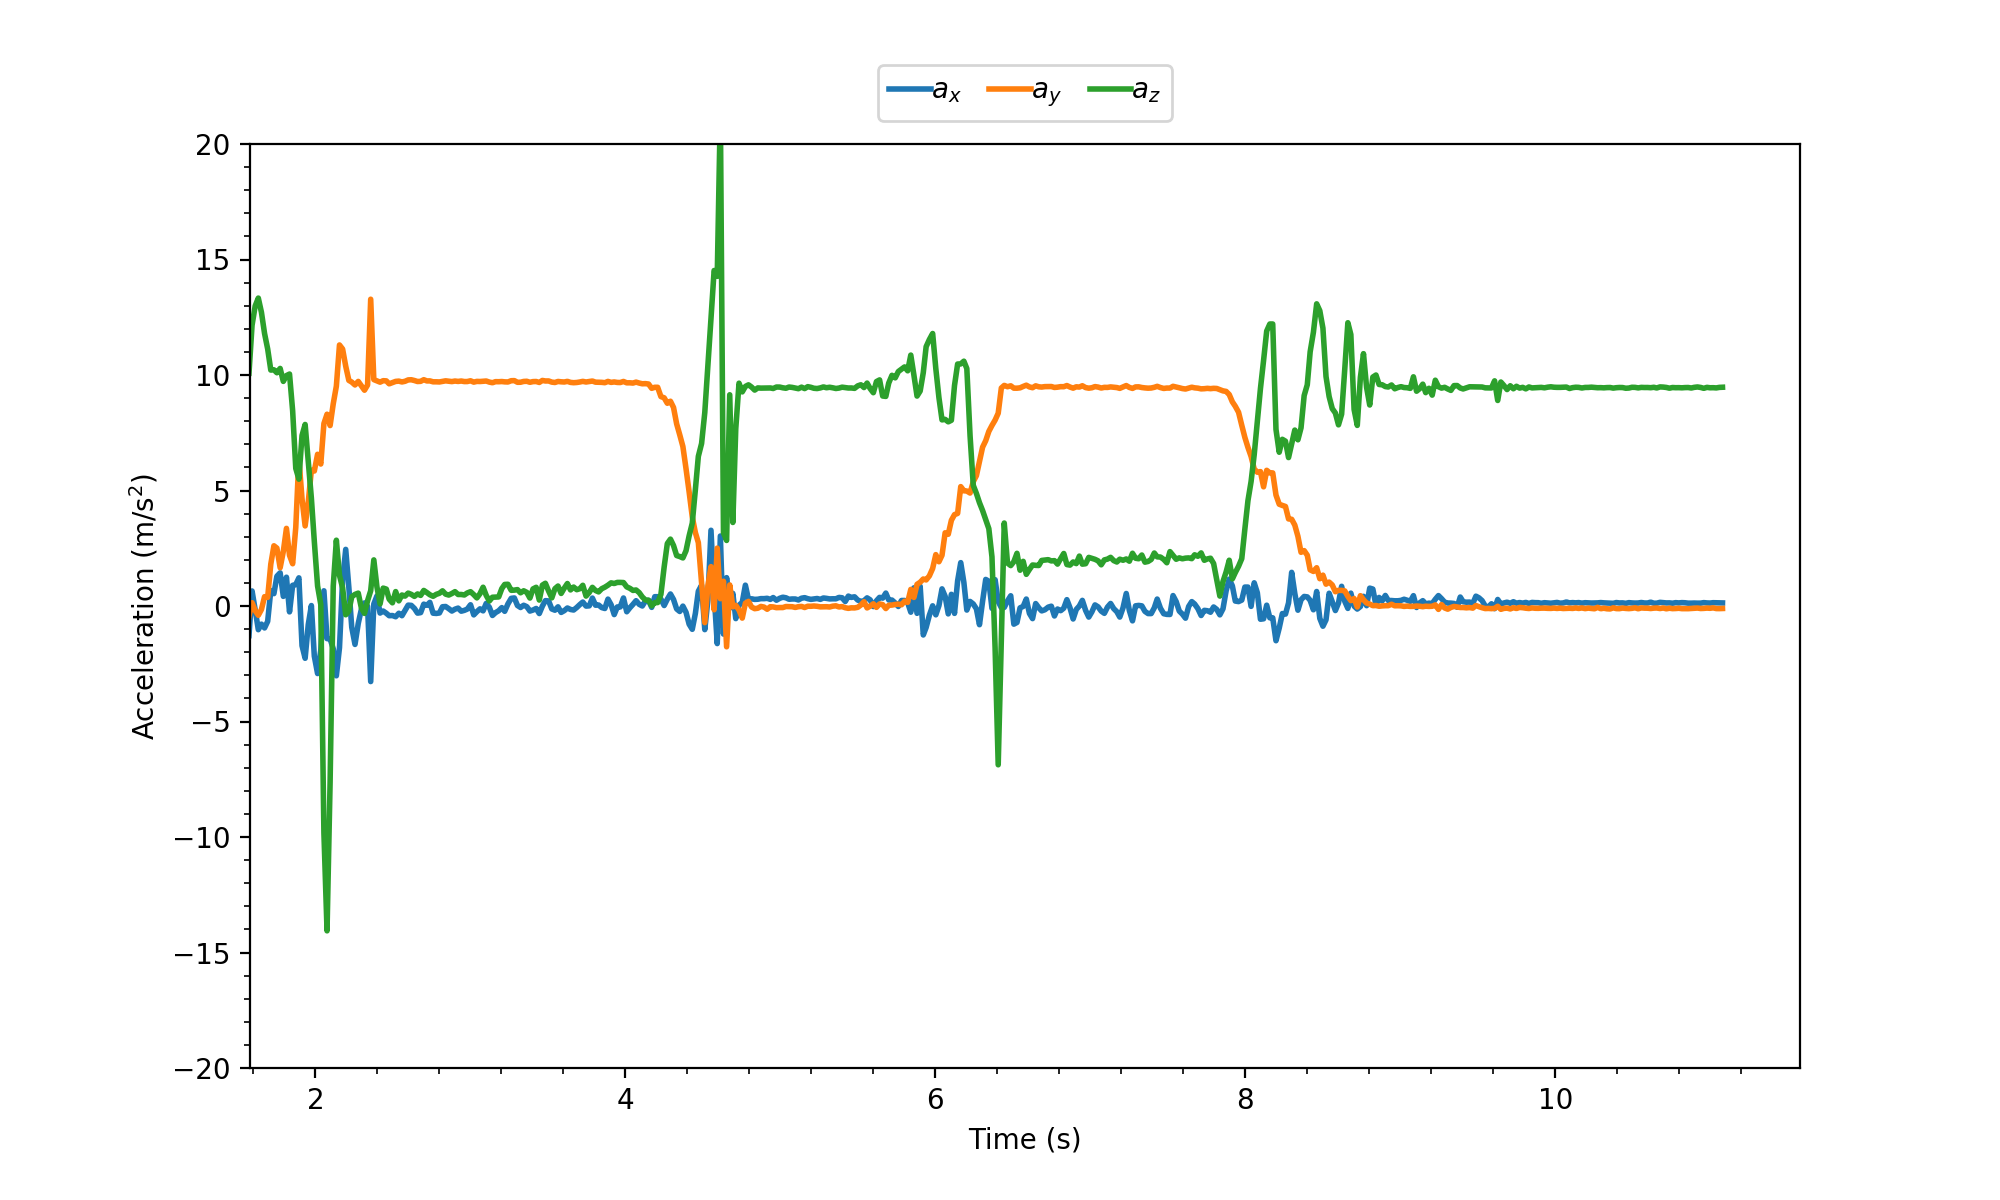

In [4]:
#using notebook magic, which works best for realtime plotting
%matplotlib notebook

### ----- Import section ------------------
# For UDP socket data transmission
import socket, traceback, string
from sys import stderr
# For plotting
#import matplotlib
#matplotlib.use('tkagg')

import matplotlib.pyplot as plt
from matplotlib import rc
#import matplotlib.animation as animation
import numpy
import time
from matplotlib.ticker import AutoMinorLocator
import matplotlib.animation as animation
from IPython.display import HTML

# ----------------------------------------

class Scope(object):
    def __init__(self, ax, hlx,hly,hlz):
        ### Initialize plot and axes
        self.ax=ax
        self.minorLocatorX   = AutoMinorLocator(5)
        self.minorLocatorY   = AutoMinorLocator(5)
        self.ax.xaxis.set_minor_locator(self.minorLocatorX)                     # ticks
        self.ax.yaxis.set_minor_locator(self.minorLocatorY)
# define data lists
        self.tlist = list()
        self.xlist = list()
        self.ylist = list()
        self.zlist = list()
        self.hlx=hlx
        self.hly=hly
        self.hlz=hlz

# --- FUNCTION TO UPDATE GRAPHS CONTENTS 
    def update(self, newmeas):
        # Append last element
        self.tlist.append(newmeas[0])
        self.xlist.append(newmeas[1])
        self.ylist.append(newmeas[2])
        self.zlist.append(newmeas[3])
        # pop out first element, if time display exceed 4.5 s
        # (this is to avoid the graph depth to grow excessive with 
        # consequences on the efficiency of the process. It can be 
        # done on the length of the buffer: e.g. if len(tlist)>maxLen: )
        if newmeas[0]-float(self.tlist[0]) > 9.5: 
            self.tlist.pop(0)
            self.xlist.pop(0)
            self.ylist.pop(0)
            self.zlist.pop(0)
#                self.ax = plt.gca()
            self.ax.set_xlim(newmeas[0]-9.5,newmeas[0]+0.5)
        # update plots
        self.hlx.set_data(self.tlist, self.xlist)
        self.hly.set_data(self.tlist, self.ylist)
        self.hlz.set_data(self.tlist, self.zlist)
        return self.hlx,self.hly,self.hlz



# SAVE TO FILE
#            print >> open("prova.txt","a"), temp, ax, ay, az
#            print temp, ax, ay, az


## MAIN Part: read data from UDP socket and call plot updater
# ---- INIT
host = ''
port = 5555
s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
s.setsockopt(socket.SOL_SOCKET, socket.SO_BROADCAST, 1)
s.bind((host, port))

def readNewData():
    # ---- READ DATA
    tstart = 0
    while 1:
        try:
            time.sleep(0.0001)
            message, address = s.recvfrom(8192)
            data = message.split( "," ) # split records using comma as delimiter (data are streamed in CSV format)
            # ---- manipulate time
            t = float(data[0])
            if (tstart==0): 
                tstart = float(data[0])
            temp = t-tstart
            # ---- get accelerometer data
            sensorID = int(data[1])
            if sensorID==3:     # sensor ID for the eccelerometer
                gx, gy, gz = float(data[2]), float(data[3]), float(data[4])
            yield [temp,gx,gy,gz]
        except GeneratorExit:
            return
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            traceback.print_exc()
            
fig=plt.figure(figsize=(10,6),edgecolor='r',facecolor='w')  # figure size
ax=plt.axes(xlim=(0,10), ylim=(-20, 20))                    # graph size
# inizialize empty plots
hlx, = plt.plot([], [], lw=2)
hly, = plt.plot([], [], lw=2)
hlz, = plt.plot([], [], lw=2)
# legend
labels = ['$a_x$','$a_y$','$a_z$']
plt.legend(labels, ncol=3, loc='upper center', 
           bbox_to_anchor=[0.5, 1.1], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=True, shadow=False)
plt.ylabel("Acceleration (m/s$^2$)")                          # labels
plt.xlabel("Time (s)")


scope=Scope(ax,hlx,hly,hlz)

# readNewData is our generator function, scope.update returns updated artists
ani = animation.FuncAnimation(fig, scope.update, readNewData, interval=1, blit=True)
plt.show()
